In [4]:
# 🧠 Research Agent using Wikipedia + GPT-3.5 Turbo 

from dotenv import load_dotenv
_ = load_dotenv()


In [5]:
from langchain.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.runnables import RunnableLambda
from langchain.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated, Optional, List
import operator


In [2]:
pip install wikipedia

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=6b0fc8d6bc59bc9fef12f8bdc0ee06cce39642de8c3a733d5eed42cfde6e6f51
  Stored in directory: /home/jovyan/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from typing import TypedDict, Annotated, Optional, List
import operator
from enum import Enum
from langchain_core.messages import AnyMessage

# 1. Define status enum
class ResearchStatus(str, Enum):
    SEARCHING = "searching"
    SUMMARIZING = "summarizing"
    COMPLETED = "completed"
    ERROR = "error"

# 2. Define ResearchState BEFORE using it
class ResearchState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]
    query: str
    raw_wikipedia: Optional[str]
    summary: Optional[str]
    status: Optional[ResearchStatus]
    errors: List[str]

# 3. Now define the initial state function
from langchain_core.messages import HumanMessage

def get_initial_state(query: str) -> ResearchState:
    return {
        "messages": [HumanMessage(content=query)],
        "query": query,
        "raw_wikipedia": None,
        "summary": None,
        "status": None,
        "errors": []
    }


In [4]:
llm = ChatOpenAI(model="gpt-3.5-turbo")
wiki = WikipediaAPIWrapper()

# 1. Wikipedia search node
def search_wikipedia(state: ResearchState) -> ResearchState:
    new_state = state.copy()
    try:
        print("Searching Wikipedia...")
        wiki_content = wiki.run(state["query"])
        new_state["raw_wikipedia"] = wiki_content
        new_state["status"] = ResearchStatus.SUMMARIZING
        new_state["messages"] += [AIMessage(content=f"Found information from Wikipedia about '{state['query']}'. Summarizing...")]
    except Exception as e:
        err = str(e)
        new_state["status"] = ResearchStatus.ERROR
        new_state["errors"].append(err)
        new_state["messages"] += [AIMessage(content=f"Error fetching Wikipedia content: {err}")]
    return new_state

# 2. Summarization node
def summarize_content(state: ResearchState) -> ResearchState:
    new_state = state.copy()
    try:
        print("Summarizing using GPT-3.5...")
        content = state["raw_wikipedia"]
        if not content:
            raise ValueError("No content to summarize.")

        prompt = f"""
        Summarize the following Wikipedia content in a clear, concise, and informative way:

        {content}

        Summary:
        """
        result = llm.invoke(prompt)
        new_state["summary"] = result.content
        new_state["status"] = ResearchStatus.COMPLETED
        new_state["messages"] += [AIMessage(content=result.content)]
    except Exception as e:
        err = str(e)
        new_state["status"] = ResearchStatus.ERROR
        new_state["errors"].append(err)
        new_state["messages"] += [AIMessage(content=f"Error during summarization: {err}")]
    return new_state

# 3. Error handling node
def handle_error(state: ResearchState) -> ResearchState:
    state["messages"] += [AIMessage(content="Research agent failed. Please check your query and try again.")]
    return state

# Build graph
def build_research_graph():
    graph = StateGraph(ResearchState)
    graph.add_node("search", search_wikipedia)
    graph.add_node("summarize", summarize_content)
    graph.add_node("handle_error", handle_error)

    graph.set_entry_point("search")

    graph.add_conditional_edges(
        "search",
        lambda state: state["status"] == ResearchStatus.ERROR,
        {
            True: "handle_error",
            False: "summarize"
        }
    )

    graph.add_conditional_edges(
        "summarize",
        lambda state: state["status"] == ResearchStatus.ERROR,
        {
            True: "handle_error",
            False: END
        }
    )

    graph.add_edge("handle_error", END)
    return graph.compile()

# Run agent
def run_research_agent(query: str):
    graph = build_research_graph()
    state = get_initial_state(query)
    final_state = graph.invoke(state)
    print("\n--- Conversation ---")
    for m in final_state["messages"]:
        role = "User" if isinstance(m, HumanMessage) else "Agent"
        print(f"{role}: {m.content}\n")

    if final_state["summary"]:
        print("\n✅ Final Summary:\n")
        print(final_state["summary"])

    return final_state

# Example usage
if __name__ == "__main__":
    user_query = input("\nEnter your research topic: ")
    run_research_agent(user_query)


Enter your research topic: AI AGENTS
Searching Wikipedia...
Summarizing using GPT-3.5...

--- Conversation ---
User: AI AGENTS

Agent: Found information from Wikipedia about 'AI AGENTS'. Summarizing...

User: AI AGENTS

Agent: Found information from Wikipedia about 'AI AGENTS'. Summarizing...

Agent: Agentic AI refers to autonomous systems that can make decisions and perform tasks without human intervention. Intelligent agents in artificial intelligence perceive their environment, take actions to achieve goals, and may improve their performance through machine learning. Manus is an autonomous AI agent developed by Monica, capable of independent thinking and decision-making. Xiao Hong, the key person behind Manus, has a background in developing AI-driven platforms for enterprise users.

User: AI AGENTS

Agent: Found information from Wikipedia about 'AI AGENTS'. Summarizing...

User: AI AGENTS

Agent: Found information from Wikipedia about 'AI AGENTS'. Summarizing...

Agent: Agentic AI 

In [1]:
import os
from langchain.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END
from enum import Enum
from typing import TypedDict, Annotated, Optional, List
import operator
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# 1. Define status enum
class ResearchStatus(str, Enum):
    SEARCHING = "searching"
    SUMMARIZING = "summarizing"
    COMPLETED = "completed"
    ERROR = "error"

# 2. Define ResearchState
class ResearchState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], operator.add]
    query: str
    raw_wikipedia: Optional[str]
    summary: Optional[str]
    status: Optional[ResearchStatus]
    errors: List[str]

# 3. Initial state function
def get_initial_state(query: str) -> ResearchState:
    return {
        "messages": [HumanMessage(content=query)],
        "query": query,
        "raw_wikipedia": None,
        "summary": None,
        "status": None,
        "errors": []
    }

# 4. Nodes
llm = ChatOpenAI(model="gpt-3.5-turbo")
wiki = WikipediaAPIWrapper()

def search_wikipedia(state: ResearchState) -> ResearchState:
    new_state = state.copy()
    try:
        print("🔎 Searching Wikipedia...")
        content = wiki.run(state["query"])
        new_state["raw_wikipedia"] = content
        new_state["status"] = ResearchStatus.SUMMARIZING
        new_state["messages"] += [AIMessage(content=f"Found information about '{state['query']}'. Summarizing...")]
    except Exception as e:
        err = str(e)
        new_state["status"] = ResearchStatus.ERROR
        new_state["errors"].append(err)
        new_state["messages"] += [AIMessage(content=f"❌ Error fetching content: {err}")]
    return new_state

def summarize_content(state: ResearchState) -> ResearchState:
    new_state = state.copy()
    try:
        print("🧠 Summarizing with GPT-3.5...")
        content = state["raw_wikipedia"]
        if not content:
            raise ValueError("No Wikipedia content to summarize.")

        prompt = f"""Summarize the following content in a concise and clear way:\n\n{content}\n\nSummary:"""
        result = llm.invoke(prompt)
        new_state["summary"] = result.content
        new_state["status"] = ResearchStatus.COMPLETED
        new_state["messages"] += [AIMessage(content=result.content)]
    except Exception as e:
        err = str(e)
        new_state["status"] = ResearchStatus.ERROR
        new_state["errors"].append(err)
        new_state["messages"] += [AIMessage(content=f"❌ Error during summarization: {err}")]
    return new_state

def handle_error(state: ResearchState) -> ResearchState:
    state["messages"] += [AIMessage(content="⚠️ Research agent failed. Please try again.")]
    return state

# 5. Build state graph
def build_research_graph():
    graph = StateGraph(ResearchState)
    graph.add_node("search", search_wikipedia)
    graph.add_node("summarize", summarize_content)
    graph.add_node("handle_error", handle_error)

    graph.set_entry_point("search")

    graph.add_conditional_edges("search", lambda s: s["status"] == ResearchStatus.ERROR, {
        True: "handle_error",
        False: "summarize"
    })

    graph.add_conditional_edges("summarize", lambda s: s["status"] == ResearchStatus.ERROR, {
        True: "handle_error",
        False: END
    })

    graph.add_edge("handle_error", END)

    return graph.compile()

# 6. Run agent
def run_research_agent(query: str):
    graph = build_research_graph()
    state = get_initial_state(query)
    final_state = graph.invoke(state)

    print("\n--- 🗣 Conversation ---")
    for m in final_state["messages"]:
        role = "User" if isinstance(m, HumanMessage) else "Agent"
        print(f"{role}: {m.content}\n")

    if final_state["summary"]:
        print("✅ Final Summary:\n")
        print(final_state["summary"])

    return final_state

# 7. CLI interface
if __name__ == "__main__":
    user_query = input("📌 Enter your research topic: ")
    run_research_agent(user_query)


/usr/local/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


📌 Enter your research topic: data
🔎 Searching Wikipedia...
🧠 Summarizing with GPT-3.5...

--- 🗣 Conversation ---
User: data

Agent: Found information about 'data'. Summarizing...

User: data

Agent: Found information about 'data'. Summarizing...

Agent: Data refers to discrete or continuous values that convey information and can be used in various fields of human activity. Debt, AIDS, Trade, Africa (DATA) is a non-governmental organization founded by Bono to address issues such as debt relief, trade rules, AIDS epidemic, and democracy in Africa. The organization received support from various sources and was recognized for their efforts in addressing these issues.

User: data

Agent: Found information about 'data'. Summarizing...

User: data

Agent: Found information about 'data'. Summarizing...

Agent: Data refers to discrete or continuous values that convey information and can be used in various fields of human activity. Debt, AIDS, Trade, Africa (DATA) is a non-governmental organizat

In [2]:
pip install langgraph langchain openai


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


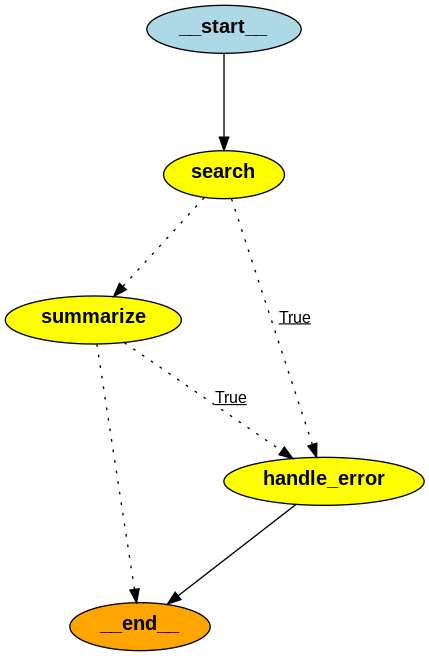

In [5]:
# --- Build the graph ---
graph = StateGraph(ResearchState)
graph.add_node("search", search_wikipedia)
graph.add_node("summarize", summarize_content)
graph.add_node("handle_error", handle_error)

graph.set_entry_point("search")

graph.add_conditional_edges(
    "search",
    lambda state: state["status"] == ResearchStatus.ERROR,
    {True: "handle_error", False: "summarize"}
)

graph.add_conditional_edges(
    "summarize",
    lambda state: state["status"] == ResearchStatus.ERROR,
    {True: "handle_error", False: END}
)

graph.add_edge("handle_error", END)

# --- Compile and display PNG ---
compiled_graph = graph.compile()
Image(compiled_graph.get_graph().draw_png())